In [69]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import xgboost as xgb
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import numpy as np

In [23]:
heart = pd.read_csv('heart.csv')
heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,28,1,2,130,132,0,2,185,0,0.0,?,?,?,0
1,29,1,2,120,243,0,0,160,0,0.0,?,?,?,0
2,29,1,2,140,?,0,0,170,0,0.0,?,?,?,0
3,30,0,1,170,237,0,1,170,0,0.0,?,?,6,0
4,31,0,2,100,219,0,1,150,0,0.0,?,?,?,0


A lot of '?' signs can be seen in the head. Analysis will be performed to see which columns can be salvaged and which if any should be dropped.

In [3]:
heart.describe()

,age,sex,cp,oldpeak,num
count,294.000000,294.000000,294.000000,294.000000,294.000000
mean,47.826531,0.724490,2.982993,0.586054,0.360544
std,7.811812,0.447533,0.965117,0.908648,0.480977
min,28.000000,0.000000,1.000000,0.000000,0.000000
25%,42.000000,0.000000,2.000000,0.000000,0.000000
50%,49.000000,1.000000,3.000000,0.000000,0.000000
75%,54.000000,1.000000,4.000000,1.000000,1.000000
max,66.000000,1.000000,4.000000,5.000000,1.000000


In [4]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         294 non-null    int64  
 1   sex         294 non-null    int64  
 2   cp          294 non-null    int64  
 3   trestbps    294 non-null    object 
 4   chol        294 non-null    object 
 5   fbs         294 non-null    object 
 6   restecg     294 non-null    object 
 7   thalach     294 non-null    object 
 8   exang       294 non-null    object 
 9   oldpeak     294 non-null    float64
 10  slope       294 non-null    object 
 11  ca          294 non-null    object 
 12  thal        294 non-null    object 
 13  num         294 non-null    int64  
dtypes: float64(1), int64(4), object(9)
memory usage: 32.3+ KB


Checking for missing data

In [24]:
cols = list(heart.columns)
for col in cols:
    print(col, any(heart[col].isna()))

age False
sex False
cp False
trestbps False
chol False
fbs False
restecg False
thalach False
exang False
oldpeak False
slope False
ca False
thal False
num        False


Counting values in each column to see if anything pops out

In [25]:
value_counts = {}

for col in cols:
    counts = {}
    for value in heart[col]:
        counts[value] = counts.get(value, 0) + 1  
    value_counts[col] = counts
    print(col,':', counts)

age : {28: 1, 29: 2, 30: 1, 31: 2, 32: 4, 33: 2, 34: 4, 35: 5, 36: 5, 37: 8, 38: 7, 39: 11, 40: 7, 41: 11, 42: 7, 43: 12, 44: 7, 45: 8, 46: 13, 47: 10, 48: 19, 49: 15, 50: 12, 51: 9, 52: 17, 53: 12, 54: 25, 55: 15, 56: 10, 57: 5, 58: 9, 59: 8, 60: 2, 61: 2, 62: 2, 63: 1, 65: 3, 66: 1}
sex : {1: 213, 0: 81}
cp : {2: 106, 1: 11, 3: 54, 4: 123}
trestbps : {'130': 54, '120': 65, '140': 50, '170': 5, '100': 6, '105': 1, '110': 21, '125': 8, '150': 23, '98': 1, '112': 3, '145': 5, '190': 1, '160': 20, '115': 2, '142': 1, '180': 6, '132': 1, '135': 5, '?': 1, '108': 1, '124': 2, '113': 1, '122': 2, '92': 1, '118': 2, '106': 1, '200': 1, '138': 1, '136': 1, '128': 1, '155': 1}
chol : {'132': 1, '243': 2, '?': 23, '237': 4, '219': 3, '198': 3, '225': 3, '254': 2, '298': 2, '161': 1, '214': 2, '220': 3, '160': 3, '167': 1, '308': 3, '264': 3, '166': 1, '340': 1, '209': 2, '260': 4, '211': 4, '173': 1, '283': 1, '194': 2, '223': 3, '315': 1, '275': 5, '297': 3, '292': 3, '182': 3, '200': 2, '204'

Picking out columns that have more than half of the values set to '?'

In [37]:
columns_drop = []
for col in cols:
    if '?' in value_counts[col].keys():
        if value_counts[col]['?'] > 294/2:
            columns_drop.append(col)
columns_drop

['slope', 'ca', 'thal']

Copying heart dataframe to a new variable and dropping columns

In [38]:
dataset = heart.copy()

for col in columns_drop:
    dataset.drop(col, axis='columns', inplace=True)

dataset.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,num
0,28,1,2,130,132,0,2,185,0,0.0,0
1,29,1,2,120,243,0,0,160,0,0.0,0
2,29,1,2,140,?,0,0,170,0,0.0,0
3,30,0,1,170,237,0,1,170,0,0.0,0
4,31,0,2,100,219,0,1,150,0,0.0,0


In [39]:
dataset['num       ']

0      0
1      0
2      0
3      0
4      0
      ..
289    1
290    1
291    1
292    1
293    1
Name: num       , Length: 294, dtype: int64

Renaming target column name

In [41]:
dataset.rename(columns={'num       ': 'target'}, inplace=True)
dataset

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,target
0,28,1,2,130,132,0,2,185,0,0.0,0
1,29,1,2,120,243,0,0,160,0,0.0,0
2,29,1,2,140,?,0,0,170,0,0.0,0
3,30,0,1,170,237,0,1,170,0,0.0,0
4,31,0,2,100,219,0,1,150,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
289,52,1,4,160,331,0,0,94,1,2.5,1
290,54,0,3,130,294,0,1,100,1,0.0,1
291,56,1,4,155,342,1,0,150,1,3.0,1
292,58,0,2,180,393,0,0,110,1,1.0,1


Processing data with sklearn Pipelines with imputation of missing data done with SimpleImputer and scaling done with MinMaxScaler, OrdinalEncoder and OneHotEncoder. ColumnTransformer used to transform the dataset.

In [44]:
numerical_features = ['age', 'trestbps', 'chol', 'thalach']
categorical_features = ['cp', 'restecg', 'oldpeak']
binary_features = ['sex', 'fbs', 'exang']

numerical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(missing_values='?', strategy='most_frequent')),
    ('scale', MinMaxScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(missing_values='?', strategy='most_frequent')),
    ('category', OrdinalEncoder())
])

binary_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(missing_values='?', strategy='most_frequent')),
    ('one-hot', OneHotEncoder())
])

full_processor = ColumnTransformer(transformers=[
    ('number', numerical_pipeline, numerical_features),
    ('categorical', categorical_pipeline, categorical_features),
    ('binary', binary_pipeline, binary_features)
])

In [45]:
full_processor.fit(dataset)

ColumnTransformer(transformers=[('number',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(missing_values='?',
                                                                strategy='most_frequent')),
                                                 ('scale', MinMaxScaler())]),
                                 ['age', 'trestbps', 'chol', 'thalach']),
                                ('categorical',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(missing_values='?',
                                                                strategy='most_frequent')),
                                                 ('category',
                                                  OrdinalEncoder())]),
                                 ['cp', 'restecg', 'oldpeak']),
                                ('binary',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(missing_values='?',
                                                                strategy='most_frequent')),
                                                 ('one-hot', OneHotEncoder())]),
                                 ['sex', 'fbs', 'exang'])])

In [46]:
dataset_processed = pd.DataFrame(full_processor.transform(dataset), columns = full_processor.get_feature_names_out())
dataset_processed

,number__age,number__trestbps,number__chol,number__thalach,categorical__cp,categorical__restecg,categorical__oldpeak,binary__sex_0,binary__sex_1,binary__fbs_0,binary__fbs_1,binary__exang_0,binary__exang_1
0,0.000000,0.351852,0.090734,0.953704,1.0,2.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,0.026316,0.259259,0.305019,0.722222,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,0.026316,0.444444,0.279923,0.814815,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3,0.052632,0.722222,0.293436,0.814815,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0.078947,0.074074,0.258687,0.629630,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,0.631579,0.629630,0.474903,0.111111,3.0,0.0,6.0,0.0,1.0,1.0,0.0,0.0,1.0
290,0.684211,0.351852,0.403475,0.166667,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
291,0.736842,0.583333,0.496139,0.629630,3.0,0.0,7.0,0.0,1.0,0.0,1.0,0.0,1.0
292,0.789474,0.814815,0.594595,0.259259,1.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0


Splitting data into train and test batches

In [52]:
num_of_columns = len(dataset_processed.columns)
X_train, X_test, y_train, y_test = train_test_split(dataset_processed.to_numpy().reshape(-1, num_of_columns), dataset['target'])

Creating and fitting an xgboost classifier

In [71]:
clf = xgb.XGBClassifier(learning_rate = 0.5, n_estimators = 100)
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Prediciton using the classifier

              precision    recall  f1-score   support

           0       0.85      0.92      0.88        49
           1       0.81      0.68      0.74        25

    accuracy                           0.84        74
   macro avg       0.83      0.80      0.81        74
weighted avg       0.84      0.84      0.83        74



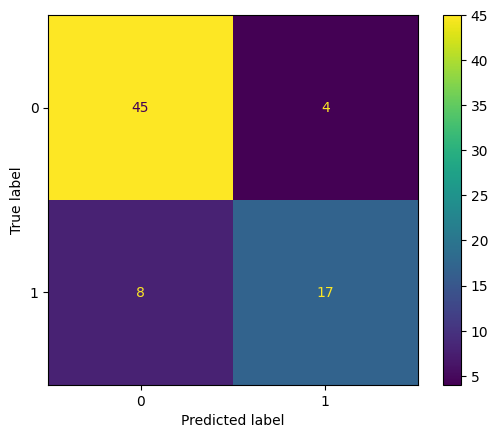

In [72]:
y_pred = clf.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
print(classification_report(y_test, y_pred))

Checking classifiers with different learning rate using GridSearch and Kfolds

In [73]:
clf_lr = xgb.XGBClassifier()
learning_rate = np.linspace(0.01, 0.1, 10)
param_grid = dict(learning_rate=learning_rate)
kfold = StratifiedKFold(n_splits=10, shuffle=True)

grid_search = GridSearchCV(clf_lr, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

print(grid_result.best_score_, grid_result.best_params_)

0.8136363636363637 {'learning_rate': 0.020000000000000004}


Diagram of mean accuracy score with std of the score

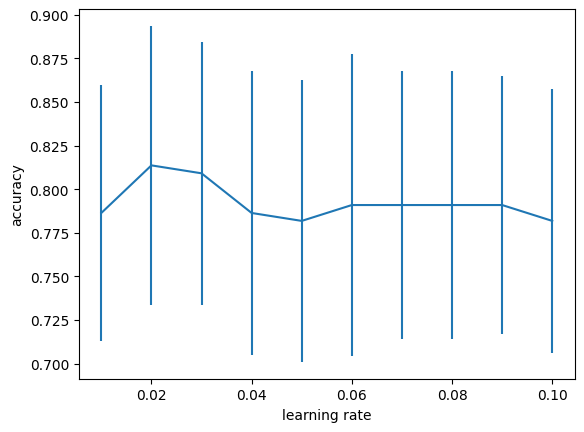

In [74]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']

plt.errorbar(learning_rate, means, yerr=stds)
plt.xlabel('learning rate')
plt.ylabel('accuracy');

Choosing the number of estimators and learning rate

In [83]:
clf_lr_est = xgb.XGBClassifier()
learning_rate = np.linspace(0.01, 0.1, 5)
n_estimators = np.arange(100, 2501, 100)
param_grid = dict(n_estimators=n_estimators,
                  learning_rate=learning_rate)
kfold = StratifiedKFold(n_splits=10, shuffle=True)

grid_search = GridSearchCV(clf_lr_est, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

print(grid_result.best_score_, grid_result.best_params_)

0.8272727272727274 {'learning_rate': 0.1, 'n_estimators': 700}


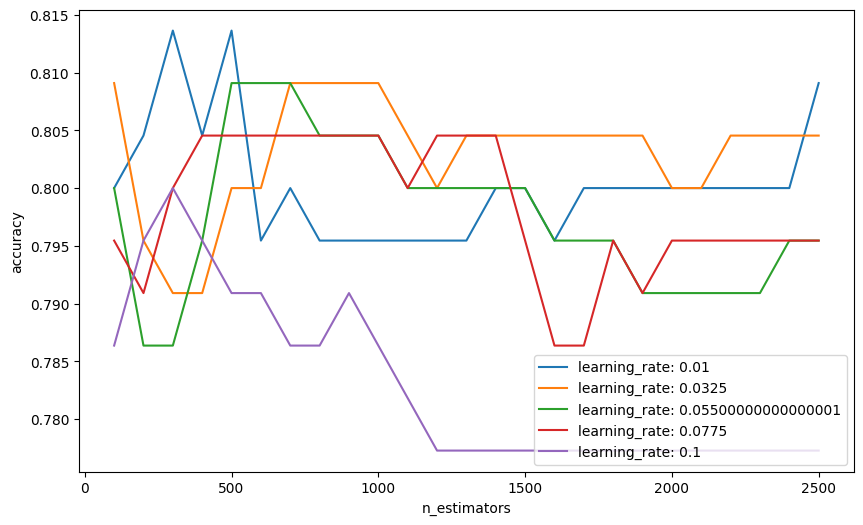

In [82]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
scores = np.array(means).reshape(len(learning_rate), len(n_estimators))

plt.figure(figsize=(10,6)) 
for i, value in enumerate(learning_rate):
    plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))   
plt.legend(loc='lower right')
plt.xlabel('n_estimators')
plt.ylabel('accuracy');

Due to the stochastic nature of the process, different parameters can provide the same results at around 82% accuracy